In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchkeras
from plotly import graph_objects as go
from sklearn.preprocessing import MinMaxScaler

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
# plt.rcParams['font.sans-serif'] = ['SimHei']

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [2]:
import os

# 文件夹名称列表
folders = [
    "result array",
    "result dataset img",
    "result feature values plot",
    "result img 1",
    "result img 2",
    "result spatial mode",
    "result time series"
]

# 创建文件夹
for folder in folders:
    os.makedirs(folder, exist_ok=True)  # exist_ok=True 表示如果文件夹已存在则不报错

# 1.读取数据

In [ ]:
W = 128
H = 128
GROUP = '1'
data = np.load(f'XXX.npy')

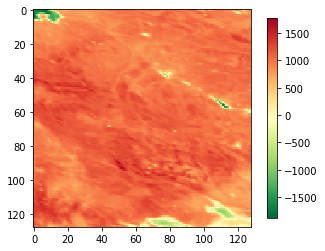

In [212]:
plt.imshow(data.mean(axis=0), interpolation='nearest', cmap='RdYlGn_r')
# plt.contourf([i for i in range(data[100].shape[1])], [i for i in range(data[100].shape[0])], np.flip(data[100],axis=0),20, cmap='YlGnBu_r')
plt.colorbar(shrink=.92)

# 2.POD分解

In [213]:
def POD_svd(X):
    '''
    input:
        X : m*n matrix with m features and n snapshot after 中心化
    return:
        k+1 : 累计方差99.5%的特征值个数
        u[:, :k+1] ： 对应特征向量 u[:,i]
        s[:k+1] ： 对应特征值列表
        vh[:k+1, :] : 时间系数矩阵 vh[i,:]
    '''
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    # s = s**2 / X.shape[1]
    s1 = s**2 / X.shape[1]
    C_per = np.cumsum(s1) / s1.sum()
    # 求累计99.5%的下标
    k = 0
    for i in range(len(C_per)):
        if C_per[i] > 0.995:
            k = i
            print(C_per[i])
            break
    return k+1, u[:, :k+1], s[:k+1], vh[:k+1, :], C_per

In [214]:
XX = data.reshape(data.shape[0], (W*H)).T
XX_mean = np.mean(XX, axis=1, keepdims=True)
XX = XX - XX_mean
print(XX.shape)

data_train = XX[:, ::2]  # 偶数时间点（t=0,2,4,...）
data_test = XX[:, 1::2]  # 奇数时间点（t=1,3,5,...）

k, u, s, vh, s_per = POD_svd(data_train)
A = vh.T
k, u.shape, s.shape, A.shape

(16384, 229)
0.9955544770435211


(106, (16384, 106), (106,), (115, 106))

In [215]:
s_per[-1]

1.0

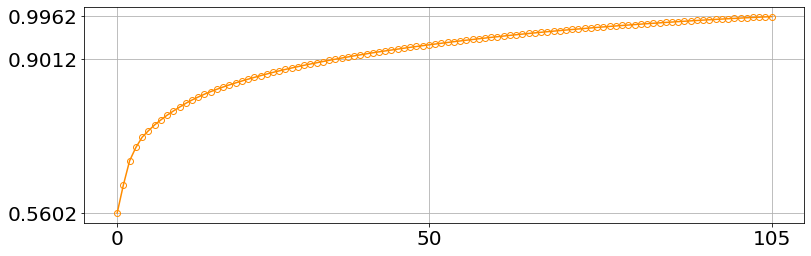

In [216]:
plt.figure(figsize=(10,3))
plt.plot(s_per[:k], marker='o', color='darkorange',markersize=6,markerfacecolor='none') # markerfacecolor='none'
plt.grid(True)
plt.tick_params(labelsize=20)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
# plt.axvline(k-1, color='r', linestyle='--')
# plt.axhline(s_per[k-1])
plt.xticks([i*50 for i in range(k // 50)] + [k-1])
plt.yticks([s_per[0], s_per[k // 3], s_per[k]])
plt.savefig(f'result feature values plot/{GROUP}.png', dpi=300, bbox_inches='tight')

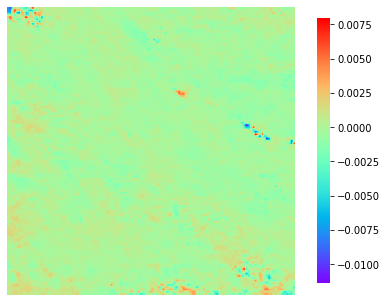

In [217]:
# 保存空间模态均值
plt.imshow(np.mean(u[:,:], axis=1, keepdims=True).reshape(W,H), cmap='rainbow')
plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
cbar = plt.colorbar(shrink=.92, pad=0.05)
cbar.outline.set_visible(False)
plt.savefig(f'result spatial mode/{GROUP}_mean.png', dpi=300, bbox_inches='tight')

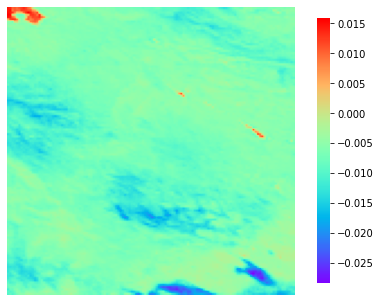

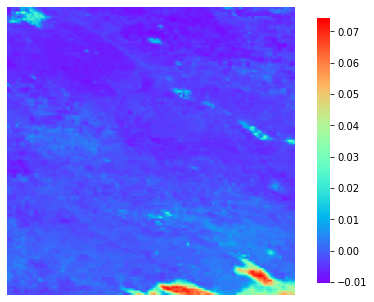

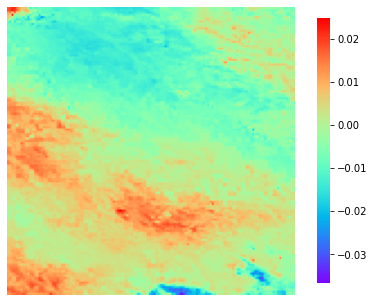

In [218]:
# 保存空间模态
for idx in range(3):
    # idx=2
    plt.figure()
    plt.imshow(u[:,idx].reshape(W,H), cmap='rainbow')
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    cbar = plt.colorbar(shrink=.92, pad=0.05)
    cbar.outline.set_visible(False)
    plt.savefig(f'result spatial mode/{GROUP}_{idx}.png', dpi=300, bbox_inches='tight')

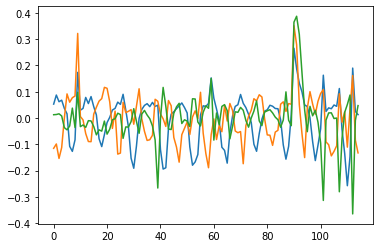

In [219]:
plt.plot(vh[0,:])
plt.plot(vh[1,:])
plt.plot(vh[2,:])

# 3.时间系数插值

In [220]:
def temporal_interpolation_only(vh):
    """
    对每个时间序列进行线性插值，仅返回中间插值点（不包含原始点）
    :param vh: shape (n_series, t)
    :return: shape (n_series, t - 1)
    """
    return (vh[:, :-1] + vh[:, 1:]) / 2

print(vh.shape)
vh_interp = temporal_interpolation_only(vh)
print(vh_interp.shape)

(106, 115)
(106, 114)


In [221]:
# 预测验证预览
# y_true = Y.cpu().numpy().squeeze()
# y_pred = model.predict(dl).detach().cpu().numpy().squeeze()

fig = go.Figure()
fig.add_trace(go.Scatter(y=vh[:, 0], name='y_true'))
fig.add_trace(go.Scatter(y=[0] + list(vh_interp[:, 0]), name='y_pred'))
fig.show()

# 4.合成

In [222]:
# A_pred = A[-65:-45, :]
A_interp = vh_interp.T
data_interp_list = []

for i in range(A_interp.shape[0]):
    # 反归一化
    img_interp = np.dot(u*s, A_interp[i])
    img_interp = img_interp.reshape(W, H)
    
    data_interp_list.append(img_interp)

data_interp = np.array(data_interp_list)
print(data_interp.min(), data_interp.max())
print(data_interp.shape)

-3794.13575969044 3596.7016335039298
(114, 128, 128)


# 评价

In [223]:
data_true = data[1::2].astype(np.float32)
# 反中心化
data_pred = data_interp + XX_mean.reshape(W, H)
print(data_true.min(), data_true.max())
print(data_pred.min(), data_pred.max())
data_min, data_max = min(data_true.min(), data_pred.min()), max(data_true.max(), data_pred.max())
print(data_min, data_max)
data_true = (data_true - data_min) / (data_max - data_min)
data_pred = (data_pred - data_min) / (data_max - data_min)

# 计算ssim, psnr, mse
ssim_list = []
psnr_list = []
mse_list = []
for i in range(len(data_interp_list)):
    img_true, img_pred = data_true[i], data_pred[i]
    print(img_true.shape, img_pred.shape)
    print(img_true.min(), img_true.max())
    print(img_pred.min(), img_pred.max())
    ssim_list.append(ssim(img_true, img_pred, data_range=1.0))
    psnr_list.append(psnr(img_true, img_pred, data_range=1.))
    mse_list.append(mse(img_true, img_pred))
    print(i, ssim_list[-1], psnr_list[-1], mse_list[-1])
    print()

# 计算平均值
avg_ssim = np.mean(ssim_list)
avg_psnr = np.mean(psnr_list)
avg_mse = np.mean(mse_list)

# 打印结果
print("Average SSIM: {:.4f}".format(avg_ssim))
print("Average PSNR: {:.2f} dB".format(avg_psnr))
print("Average MSE: {:.6f}".format(avg_mse))
print(f'k:{k}')

# # 计算像素序列评价指标
# mse_list = []
# rmse_list = []
# r2_list = []
# # for i in range(len(data_pred_list)):
# #     img_true, img_pred = data_true[i], data_pred[i]
# for i in range(W):
#     for j in range(H):
#         pixel_true, pixel_pred = data_true[:, i, j], data_pred[:, i, j]
#         # print(pixel_true[:10])
#         # print(pixel_pred[:10])
#         mse_list.append(mse(pixel_true, pixel_pred))
#         rmse_list.append(np.sqrt(mse(pixel_true, pixel_pred)))
#         r2_list.append(r2_score(pixel_true, pixel_pred))
#         # r2_list.append(1-mse(pixel_true, pixel_pred)/ np.var(pixel_true))

# # 计算平均值
# avg_mse1 = np.mean(mse_list)
# avg_rmse = np.mean(rmse_list)
# avg_r2 = np.mean(r2_list)

# # 打印结果
# print("Average MSE: {:.6f}".format(avg_mse1))
# print("Average RMSE: {:.6f}".format(avg_rmse))
# print("Average R2: {:.6f}".format(avg_r2))

-3000.0 8476.0
-3428.678804966461 4620.780113004983
-3428.678804966461 8476.0
(128, 128) (128, 128)
0.036009263 0.5155686
0.02631366070015114 0.4460278148068301
0 0.9017941326868553 32.68050319139999 0.000539448116222705

(128, 128) (128, 128)
0.036009263 0.66483766
0.03192938138434628 0.44164608831510827
1 0.9322912845619891 34.52724162542216 0.0003525947466906783

(128, 128) (128, 128)
0.036009263 0.5890691
0.028751033678777866 0.4174128649291605
2 0.9118139147279407 34.064937188912225 0.00039219881857977836

(128, 128) (128, 128)
0.036009263 0.4584482
0.027593178006087404 0.4205419257230336
3 0.9695963878023537 37.923700091348735 0.00016129837453670922

(128, 128) (128, 128)
0.036009263 0.41056788
0.029111520209293647 0.40524963579923273
4 0.9699092264196204 38.62102704386337 0.0001373717072305711

(128, 128) (128, 128)
0.036009263 0.47743234
0.023429687671062467 0.4681321170911365
5 0.9310108661976219 36.398239165835435 0.0002291796666619438

(128, 128) (128, 128)
0.036009263 0.578

In [224]:
data_true.shape, data_pred.shape

((114, 128, 128), (114, 128, 128))

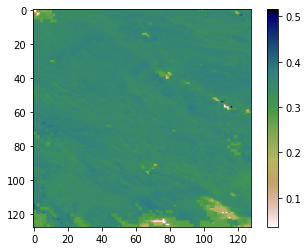

In [225]:
plt.imshow(data_true[0], cmap='gist_earth_r')
plt.colorbar()

In [226]:
# 保存图片
# top = cm.get_cmap('Oranges_r', 128)
# bottom = cm.get_cmap('Blues', 128)
# newcolors = np.vstack((top(np.linspace(0, 1, 128)),
#                     bottom(np.linspace(0, 1, 128))))
# newcmp = mpl.colors.ListedColormap(newcolors, name='OrangeBlue')
# newcmp = cm.get_cmap("gist_earth_r").copy() 
cmap_name = 'gist_earth_r'


data_true = data_true * (data_max - data_min) + data_min
data_pred = data_pred * (data_max - data_min) + data_min
print(data_true.min(), data_true.max())
print(data_pred.min(), data_pred.max())

np.save(f'result array/{GROUP}.npy', data_pred)

# 反归一化
# data_true *= 13000
# data_pred *= 13000
os.makedirs(f'result img/{GROUP}', exist_ok=True)

for i in range(len(data_interp_list)):
    print(i, data_true[i].shape, data_pred[i].shape)
    print(i, data_pred[i].min(), data_pred[i].max())
    # plt.imsave(f'result img/{GROUP}/{i+1}_true.png', data_true[i])
    # plt.imsave(f'result img/{GROUP}/{i+1}_pred.png', data_pred[i])
    
#     plt.figure()
#     plt.imshow(data_true[i], cmap=newcmp)    # Spectral
#     plt.axis('off')
#     plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
#     plt.margins(0, 0)
#     cbar = plt.colorbar(shrink=.92)
#     cbar.outline.set_visible(False)
#     plt.axis('off')
#     plt.savefig(f'result img 1/{GROUP}/{i+1}_true.png', dpi=300, bbox_inches='tight')


#     plt.figure()
#     plt.imshow(data_pred[i], cmap=newcmp)    # Spectral
#     plt.axis('off')
#     plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
#     plt.margins(0, 0)
#     cbar = plt.colorbar(shrink=.92)
#     cbar.outline.set_visible(False)
#     plt.axis('off')
#     plt.savefig(f'result img 1/{GROUP}/{i+1}_pred.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.imshow(data_true[i], cmap=cmap_name)    # Spectral
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    cbar = plt.colorbar(shrink=.92)
    cbar.outline.set_visible(False)
    plt.axis('off')
    plt.savefig(f'result img/{GROUP}/{i+1}_true.png', dpi=300, bbox_inches='tight')
    plt.close()


    norm = mpl.colors.Normalize(vmin=data_true[i].min(), vmax=data_true[i].max())
    plt.figure()
    plt.imshow(data_pred[i], cmap=cmap_name, norm=norm)    # Spectral
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    cbar = plt.colorbar(shrink=.92)
    cbar.outline.set_visible(False)
    plt.axis('off')
    plt.savefig(f'result img/{GROUP}/{i+1}_pred.png', dpi=300, bbox_inches='tight')
    plt.close()

-3000.0 8476.0
-3428.678804966461 4620.780113004983
0 (128, 128) (128, 128)
0 -3115.423126148293 1881.1390683899153
1 (128, 128) (128, 128)
1 -3048.569775144543 1828.976021894754
2 (128, 128) (128, 128)
2 -3086.4069837098373 1540.4872810760444
3 (128, 128) (128, 128)
3 -3100.1908835957256 1577.7377447883173
4 (128, 128) (128, 128)
4 -3082.11550735053 1395.6879450530423
5 (128, 128) (128, 128)
5 -3149.7558987417797 2144.283687292469
6 (128, 128) (128, 128)
6 -3200.172721836411 3014.3998296389846
7 (128, 128) (128, 128)
7 -3193.833860740991 2660.5480955711346
8 (128, 128) (128, 128)
8 -2169.451228434171 4526.233648297599
9 (128, 128) (128, 128)
9 -2112.599263925261 4341.190843472796
10 (128, 128) (128, 128)
10 -3163.3314750685286 1411.747449829949
11 (128, 128) (128, 128)
11 -2387.8217604299166 1378.1297636714016
12 (128, 128) (128, 128)
12 -3029.8237284045344 1358.1495219196686
13 (128, 128) (128, 128)
13 -3079.3171666718317 1233.0009255584237
14 (128, 128) (128, 128)
14 -2420.256811386

In [227]:
'''
1: :, :H, :W
Average SSIM: 0.7381
Average PSNR: 30.07 dB
Average MSE: 0.001347
k:110

2: :, :H, W:W*2
num_layers = 3
Average SSIM: 0.6529
Average PSNR: 26.12 dB
Average MSE: 0.002813
Average RMSE: 0.052326
Average R2: -0.173655

3: :, -H:, -W:
num_layers = 3
Average SSIM: 0.5834
Average PSNR: 20.33 dB
Average MSE: 0.012902
Average RMSE: 0.108955
Average R2: 0.237003

4: :, H*10:H*11, W*10:W*11
num_layers = 2
Average SSIM: 0.8308
Average PSNR: 30.21 dB
Average MSE: 0.001224
Average RMSE: 0.031985
Average R2: 0.136303

5: :, H*20:H*21, W*20:W*21
num_layers: 2
Average SSIM: 0.8478
Average PSNR: 29.18 dB
Average MSE: 0.002077
Average RMSE: 0.040476
Average R2: 0.152842

6: :, :H, W*20:W*21
num_layers: 2
Average SSIM: 0.8301
Average PSNR: 28.06 dB
Average MSE: 0.002555
Average RMSE: 0.033899
Average R2: -0.306045

7: :, :H, W*30:W*31
num_layers: 3
Average SSIM: 0.9017
Average PSNR: 37.34 dB
Average MSE: 0.000222
Average RMSE: 0.013487
Average R2: -0.286298

8: :, H*30:H*31, W*3:W*4
num_layers: 3
Average SSIM: 0.7966
Average PSNR: 29.01 dB
Average MSE: 0.001557
Average RMSE: 0.035280
Average R2: 0.183327

9: :, H*20:H*21, W*13:W*14
num_layers: 3
Average SSIM: 0.8045
Average PSNR: 27.99 dB
Average MSE: 0.001985
Average RMSE: 0.041576
Average R2: 0.223531

10:, H*20:H*21, W*5:W*6
num_layers: 3
Average SSIM: 0.8792
Average PSNR: 30.34 dB
Average MSE: 0.001268
Average RMSE: 0.033020
Average R2: 0.068472

11: ningxia
num_layers: 2
Average SSIM: 0.9577
Average PSNR: 33.41 dB
Average MSE: 0.001244

num_layers: 2
Average SSIM: 0.8837
Average PSNR: 28.80 dB
Average MSE: 0.009091

num_layers = 2
time_step = 5
Average SSIM: 0.9219
Average PSNR: 32.43 dB
Average MSE: 0.001628

'''

'\n1: :, :H, :W\nAverage SSIM: 0.7381\nAverage PSNR: 30.07 dB\nAverage MSE: 0.001347\nk:110\n\n2: :, :H, W:W*2\nnum_layers = 3\nAverage SSIM: 0.6529\nAverage PSNR: 26.12 dB\nAverage MSE: 0.002813\nAverage RMSE: 0.052326\nAverage R2: -0.173655\n\n3: :, -H:, -W:\nnum_layers = 3\nAverage SSIM: 0.5834\nAverage PSNR: 20.33 dB\nAverage MSE: 0.012902\nAverage RMSE: 0.108955\nAverage R2: 0.237003\n\n4: :, H*10:H*11, W*10:W*11\nnum_layers = 2\nAverage SSIM: 0.8308\nAverage PSNR: 30.21 dB\nAverage MSE: 0.001224\nAverage RMSE: 0.031985\nAverage R2: 0.136303\n\n5: :, H*20:H*21, W*20:W*21\nnum_layers: 2\nAverage SSIM: 0.8478\nAverage PSNR: 29.18 dB\nAverage MSE: 0.002077\nAverage RMSE: 0.040476\nAverage R2: 0.152842\n\n6: :, :H, W*20:W*21\nnum_layers: 2\nAverage SSIM: 0.8301\nAverage PSNR: 28.06 dB\nAverage MSE: 0.002555\nAverage RMSE: 0.033899\nAverage R2: -0.306045\n\n7: :, :H, W*30:W*31\nnum_layers: 3\nAverage SSIM: 0.9017\nAverage PSNR: 37.34 dB\nAverage MSE: 0.000222\nAverage RMSE: 0.013487\nA